## Bachelor Thesis - Informatik

### Variante 2 :
### Multiclass-Klassifizierung mit 2D Convolutional Neuronal Network
***

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">

##### ▶️ Installation notwendiger Python-Bibliotheken
***

In [15]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install -U seaborn-image
#%pip install matplotlib.pyplot
#%pip install scikit-learn

##### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [16]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

from tensorflow import keras # type: ignore
from keras import layers # type: ignore


##### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner<br>
****


In [17]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################

for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Eigene/P1L' + label + '.csv', sep=',', header=None))    
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Eigene/P2L' + label + '.csv', sep=',', header=None))    
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Eigene/P3L' + label + '.csv', sep=',', header=None))    
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Eigene/P4L' + label + '.csv', sep=',', header=None))    
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([proband1, proband2, proband3, proband4]).reset_index(drop=True)

##### ▶️ Umwandlung in geeignete Datenstrukturen
****
☑️ Erzeugte Strukturen haben das Format 16 x 64<br>
****


In [18]:
def split_dataframe(df, n, reminder = None):
    # Get number of rows in DataFrame
    total_rows = len(df)
    
    # Initialize list to hold the split DataFrames
    dfs = []
    
    # Calculate the number of DataFrames
    num_dfs = total_rows // n
    extra_rows = total_rows % n
    
    if reminder == 'first' and extra_rows > 0:
        # Size of first chunk is equal to reminder. Remaining chunks are same size.
        dfs.append(df.iloc[:n + extra_rows])
        start_idx = n + extra_rows
        for _ in range(1, num_dfs):
            dfs.append(df.iloc[start_idx:start_idx + n])
            start_idx += n
    elif reminder == 'last' and extra_rows > 0:
        # Last chunk consists of remining rows. The other chunks are the same size.
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
        # Add extra rows to the last chunk
        dfs.append(df.iloc[num_dfs*n:])
    elif reminder == 'spread':
        # Evenly spread extra rows across the first few chunks
        for i in range(num_dfs + (1 if extra_rows > 0 else 0)):
            size = n + (1 if i < extra_rows else 0)
            dfs.append(df.iloc[i*size:min((i+1)*size, total_rows)])
    else:
        if extra_rows > 0:
            raise ValueError(f"DataFrame Länge ist nicht teilbar durch {n}. Bitte nutze den 'reminder' Parameter.")
        # If remainder is None and the DataFrame is perfectly divisible
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
    
    return dfs


##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
Labels = all_data[all_data.columns[-1]]
 

##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
Klassen = np.unique(Labels)
print("Form der Klassen : ", Klassen.shape)


##############################################################
# Sensorwerte der Gesten auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
Features = all_data.drop(64, axis=1).copy()


##############################################################
# Zerteile Gesamtdaten in Einzelpakete mit jeweils 16 Zeilen #
# Datentyp Python List                                       #
##############################################################
Features = split_dataframe(Features, 16, 'last')
Labels = split_dataframe(Labels, 16, 'last')


##############################################################
# Entferne letztes Tupel aus Listen                          #
# Bei ungerader Anzahl Tupeln hat das letzte Listenelement   #
# eine abweichende Anzahl an Datenpunkten --> Problem        #
# Datentyp Python List                                       #
##############################################################
l_Features = len(Features)-1
Features = Features[:l_Features]

l_Labels = len(Labels)-1
Labels = Labels[:l_Labels]


##############################################################
# Konvertiere die Listen in Numpy-Arrays als Float32         #
# Dann eine Dimension hinzu als Channel                      #
# Datentyp Numpy-Array                                       #
##############################################################
Features = np.array(Features).astype('float32')
Features = np.expand_dims(Features, -1)


##############################################################
# Zuerst alle Label-Arrays nach 1D konvertieren              #
# Dann eine Dimension hinzu als Channel                      #
# Wichtig für das Convolution Neuronal Network !!            #
##############################################################
Labels = np.array(Labels).astype('int')
Labels = Labels[:,1]
Labels = np.expand_dims(Labels, -1)


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Form der Features : ", Features.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Form der Labels : ", Labels.shape)

Form der Klassen :  (4,)
Form der Features :  (378, 16, 64, 1)
Form der Labels :  (378, 1)


### ▶️ Datensatz aufteilen in Training- und Test-Daten
***

In [19]:
##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fixwert 4                                                  #
##############################################################
num_classes = Klassen.size


##############################################################
# Fix 64 Sensorwerte pro Zeile --> (16, 64, 1)               #
##############################################################
input_shape = (16, 64, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = 0.3, random_state = 100) # type: ignore


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("Form der Training-Features : ", X_train.shape)
print("Form der Test-Features : ", X_test.shape)
print("Form der Training-Labels : ", y_train.shape)
print("Form der Test-Labels : ", y_test.shape)
print()
print(Features.shape[0], "Gesamt-Features")
print(X_train.shape[0], "Training-Features")
print(X_test.shape[0], "Test-Features")
print()
print(Labels.shape[0], "Gesamt-Labels")
print(y_train.shape[0], "Training-Labels")
print(y_test.shape[0], "Test-Labels")


##############################################################
# Klassenvektor in Matrize konvertieren (One-Hot-Encoding)   #
##############################################################
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Form der Training-Features :  (264, 16, 64, 1)
Form der Test-Features :  (114, 16, 64, 1)
Form der Training-Labels :  (264, 1)
Form der Test-Labels :  (114, 1)

378 Gesamt-Features
264 Training-Features
114 Test-Features

378 Gesamt-Labels
264 Training-Labels
114 Test-Labels


#### ▶️ Modellarchitektur
***

In [20]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch_size = 32
epochs = 16
initializer='glorot_uniform'
padding='same'
mom = 0.9
eps = 0.000001
drop = 0.2


##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))

model.add(layers.Conv2D(96, (4,4), strides=(2,2) ,padding = padding, input_shape=input_shape, kernel_initializer=initializer))
model.add(layers.BatchNormalization(momentum=mom, epsilon=eps))
model.add(layers.Activation('elu'))
model.add(layers.MaxPool2D(2,2))

model.add(layers.Conv2D(64, (4,4), strides=(2,2) , padding = padding))
model.add(layers.BatchNormalization(momentum=mom, epsilon=eps))
model.add(layers.Activation('elu'))
model.add(layers.MaxPool2D(2,2))


model.add(layers.Flatten())
model.add(layers.Dense(256))

model.add(layers.Activation('elu'))
model.add(layers.Dropout(drop))


model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

# Modellparameter ausgeben
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 32, 96)         1632      
                                                                 
 batch_normalization_2 (Bat  (None, 8, 32, 96)         384       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 8, 32, 96)         0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 16, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 8, 64)          98368     
                                                                 
 batch_normalization_3 (Bat  (None, 2, 8, 64)         

In [21]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_split=0.3,
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),        
    ]
)

Epoch 1/16
6/6 [==============================] - 1s 51ms/step - loss: 1.7291 - accuracy: 0.3696 - val_loss: 1.4930 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 2/16
6/6 [==============================] - 0s 17ms/step - loss: 0.9342 - accuracy: 0.6630 - val_loss: 1.6008 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 3/16
6/6 [==============================] - 0s 17ms/step - loss: 0.4907 - accuracy: 0.8098 - val_loss: 1.0268 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/16
6/6 [==============================] - 0s 18ms/step - loss: 0.3090 - accuracy: 0.9402 - val_loss: 1.0835 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 5/16
6/6 [==============================] - 0s 17ms/step - loss: 0.1557 - accuracy: 1.0000 - val_loss: 0.9667 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/16
6/6 [==============================] - 0s 18ms/step - loss: 0.1165 - accuracy: 0.9891 - val_loss: 0.9032 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 7/16
6/6 [==============================] - 0s 18ms/step - loss: 0.0679 - accuracy

### ▶️ Ausgabe der Funktionen für Verlust und Genauigkeit

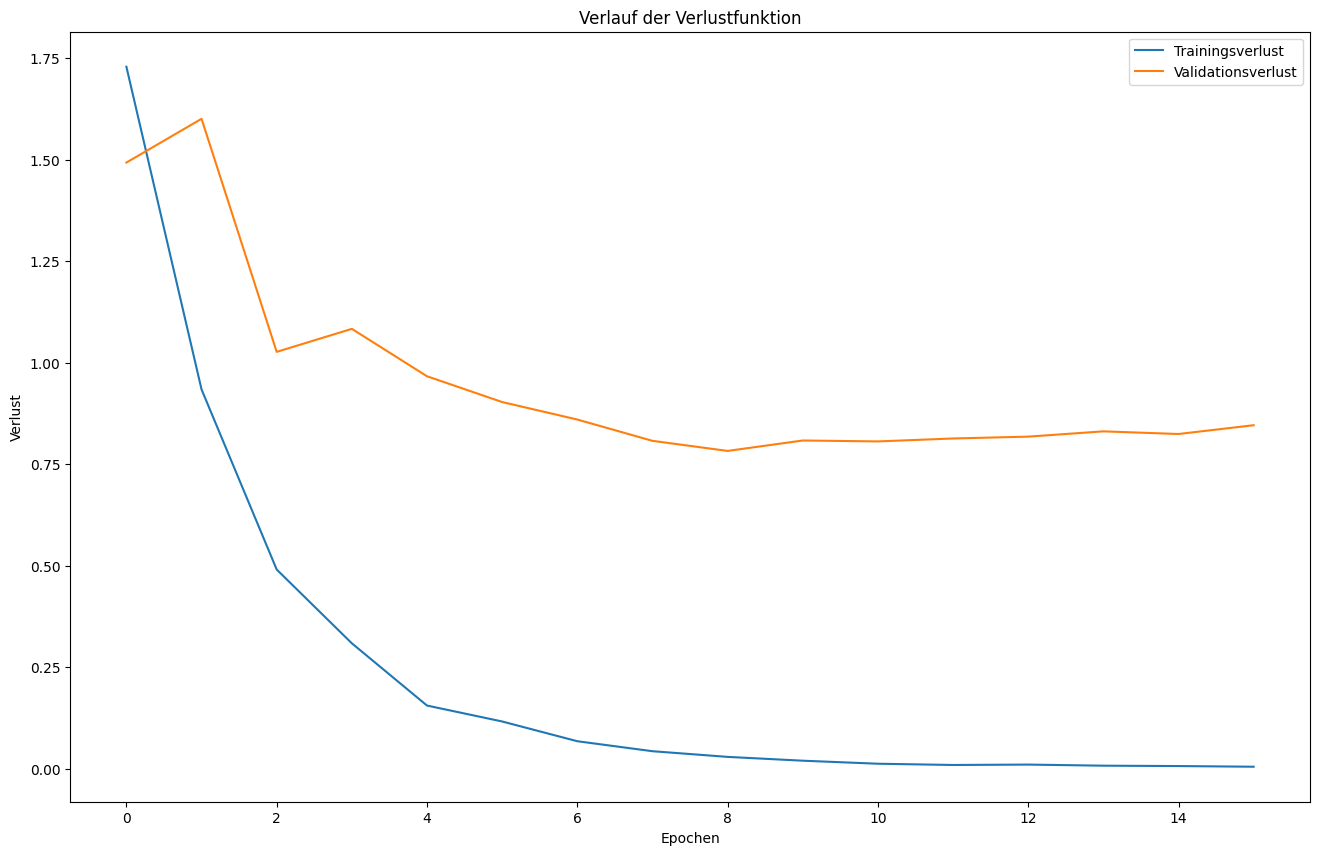

In [22]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

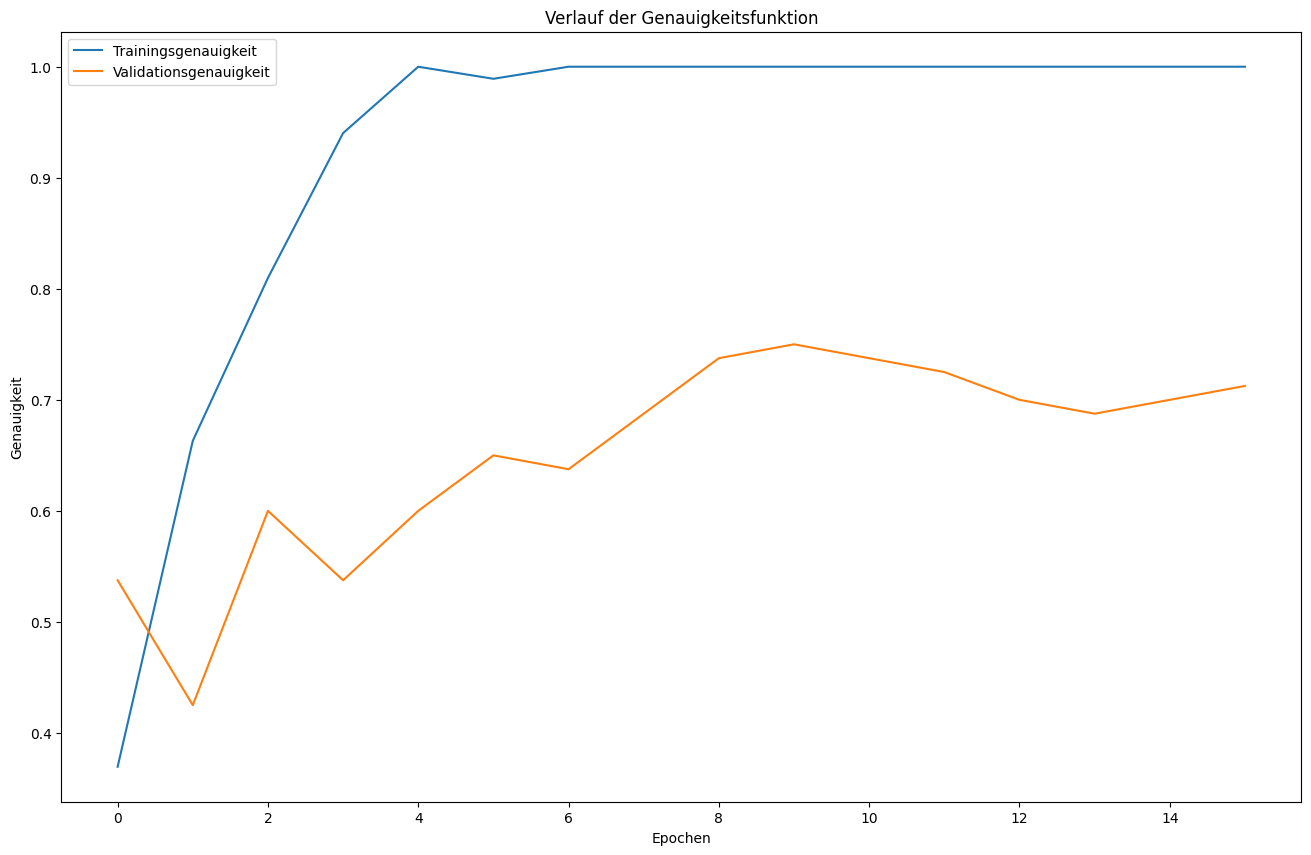

In [23]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

### ▶️ Scores zur Beurteilung der Modellqualität 

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Testverlust :", score[0])
print("Testgenauigkeit :", score[1])

Testverlust : 0.9963662624359131
Testgenauigkeit : 0.6228070259094238


In [25]:
y = model.predict(np.array(Features))[49]
print("Es handelt sich um Geste : " + str(np.argmax(y)))

12/12 [==============================] - 0s 5ms/step
Es handelt sich um Geste : 2


### ▶️ Metriken zur Beurteilung der Modellqualität 

4/4 [==============================] - 0s 5ms/step


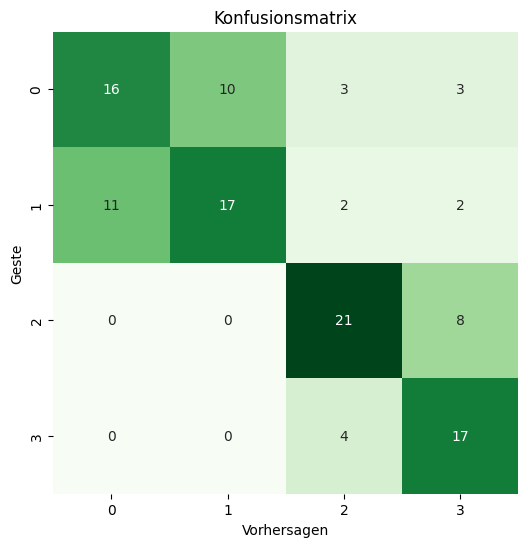

              precision    recall  f1-score   support

           0       0.59      0.50      0.54        32
           1       0.63      0.53      0.58        32
           2       0.70      0.72      0.71        29
           3       0.57      0.81      0.67        21

    accuracy                           0.62       114
   macro avg       0.62      0.64      0.62       114
weighted avg       0.63      0.62      0.62       114



In [26]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)
 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))
